
# Proyecto ML — Telecom/Redes (UCI): **Internet Firewall Data** — Versión por modelos (v4)

**Objetivo:** predecir la **acción del firewall** (`Action`) a partir de métricas de tráfico.  
**Clases:** `allow`, `deny`, `drop`, `reset-both` (desbalanceadas).

> Cada modelo entrena en **su propia celda** (GridSearchCV + classification report con OOF).  
> Al final, se genera la **comparativa**, se elige el mejor y se guarda con `joblib`.


In [ ]:

import os, json, warnings, pathlib
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# XGBoost
try:
    from xgboost import XGBClassifier
except Exception:
    print("xgboost no instalado (opcional).")
    XGBClassifier = None

# SMOTE
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    HAS_IMBLEARN = True
except Exception:
    HAS_IMBLEARN = False
    print("imbalanced-learn no instalado (opcional).")

import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
plt.rcParams["figure.figsize"] = (7,4)

results = {}
reports = {}


## 1) Carga del dataset

In [2]:


# Ajusta esta ruta a tu entorno local
df = pd.read_csv(r'D:\29092025\DESKTOP\Machine\ml_project\log2.csv')
df.shape


(65532, 12)

In [3]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


## 2) EDA

In [5]:
df.isna().mean().sort_values(ascending=False)

Source Port             0.0
Destination Port        0.0
NAT Source Port         0.0
NAT Destination Port    0.0
Action                  0.0
Bytes                   0.0
Bytes Sent              0.0
Bytes Received          0.0
Packets                 0.0
Elapsed Time (sec)      0.0
pkts_sent               0.0
pkts_received           0.0
dtype: float64

In [6]:

target_col = "Action"
class_counts = df[target_col].value_counts()
class_counts


Action
allow         37640
deny          14987
drop          12851
reset-both       54
Name: count, dtype: int64

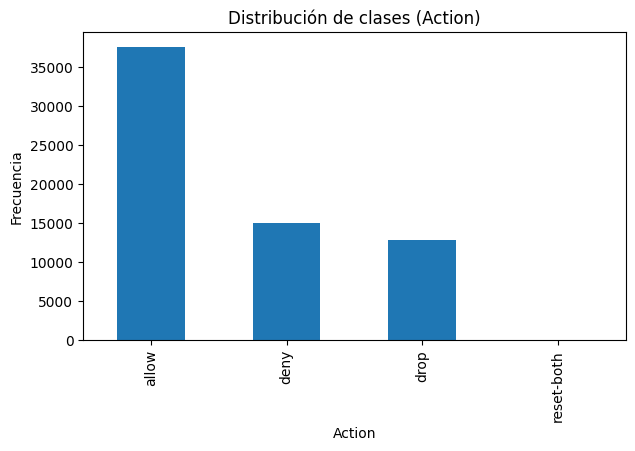

In [7]:

class_counts.plot(kind='bar', title='Distribución de clases (Action)')
plt.xlabel('Action'); plt.ylabel('Frecuencia'); plt.show()


In [8]:

num_cols = [c for c in df.columns if c != target_col]
df[num_cols].describe().T.sort_values('std', ascending=False).head(15)


,count,mean,std,min,25%,50%,75%,max
Bytes,65532.0,97123.950085,5.618439e+06,60.0,66.0,168.0,752.25,1.269359e+09
Bytes Sent,65532.0,22385.796908,3.828139e+06,60.0,66.0,90.0,210.00,9.484772e+08
Bytes Received,65532.0,74738.153177,2.463208e+06,0.0,0.0,79.0,449.00,3.208818e+08
NAT Source Port,65532.0,19282.972761,2.197069e+04,0.0,0.0,8820.5,38366.25,6.553500e+04
Destination Port,65532.0,10577.385812,1.846603e+04,0.0,80.0,445.0,15000.00,6.553500e+04
Source Port,65532.0,49391.969343,1.525571e+04,0.0,49183.0,53776.5,58638.00,6.553400e+04
NAT Destination Port,65532.0,2671.049930,9.739162e+03,0.0,0.0,53.0,443.00,6.553500e+04
Packets,65532.0,102.866035,5.133002e+03,1.0,1.0,2.0,6.00,1.036116e+06
pkts_sent,65532.0,41.399530,3.218871e+03,1.0,1.0,1.0,3.00,7.475200e+05
pkts_received,65532.0,61.466505,2.223332e+03,0.0,0.0,1.0,2.00,3.272080e+05


## 3) Preprocesamiento y utilidades

In [9]:

X = df.drop(columns=[target_col])
y_text = df[target_col].astype(str)

le = LabelEncoder()
y = le.fit_transform(y_text)

numeric_features = X.columns.tolist()
numeric_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                      ('scaler', StandardScaler())])
preprocess = ColumnTransformer([('num', numeric_transformer, numeric_features)])
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

def summarize_cv(best_estimator, X, y, model_name, classes):
    y_pred_oof = cross_val_predict(best_estimator, X, y, cv=cv, n_jobs=-1)
    rep = classification_report(y, y_pred_oof, target_names=classes, digits=4)
    print(rep)
    reports[model_name] = rep
    cm = confusion_matrix(y, y_pred_oof)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(xticks_rotation=45); plt.title(f"Matriz de confusión — {model_name} (OOF)"); plt.show()

def collect_scores(best_estimator, X, y):
    acc = cross_val_score(best_estimator, X, y, cv=cv, scoring='accuracy', n_jobs=-1).mean()
    f1m = cross_val_score(best_estimator, X, y, cv=cv, scoring='f1_macro', n_jobs=-1).mean()
    bal = cross_val_score(best_estimator, X, y, cv=cv, scoring='balanced_accuracy', n_jobs=-1).mean()
    return acc, f1m, bal


## 4.1 Decision Tree

Best params: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}
CV => acc=0.9981 | f1_macro=0.8897 | bal_acc=0.8668

              precision    recall  f1-score   support

       allow     0.9999    0.9996    0.9998     37640
        deny     0.9948    0.9969    0.9958     14987
        drop     0.9971    0.9972    0.9972     12851
  reset-both     0.7879    0.4815    0.5977        54

    accuracy                         0.9981     65532
   macro avg     0.9449    0.8688    0.8976     65532
weighted avg     0.9980    0.9981    0.9980     65532



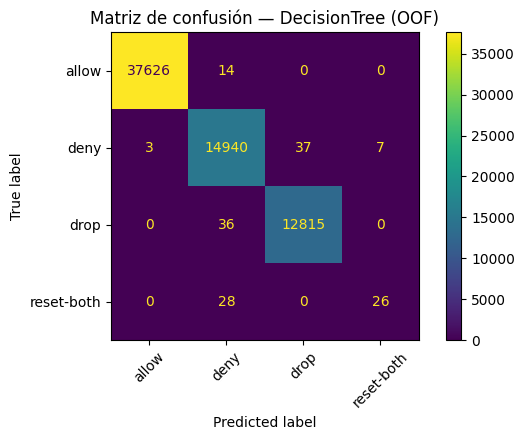

In [10]:

pipe_dt = Pipeline([('prep', preprocess),
                    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
grid_dt = {'clf__criterion': ['gini', 'entropy', 'log_loss'],
           'clf__max_depth': [None, 10, 20, 30],
           'clf__min_samples_split': [2, 10, 20],
           'clf__min_samples_leaf': [1, 2, 5]}
gs_dt = GridSearchCV(pipe_dt, grid_dt, cv=cv, scoring='f1_macro', n_jobs=-1, refit=True)
gs_dt.fit(X, y); best_dt = gs_dt.best_estimator_
acc, f1m, bal = collect_scores(best_dt, X, y)
results['DecisionTree'] = {'accuracy_cv': acc, 'f1_macro_cv': f1m, 'balanced_accuracy_cv': bal,
                           'best_params': gs_dt.best_params_, 'best_estimator': best_dt}
print("Best params:", gs_dt.best_params_)
print(f"CV => acc={acc:.4f} | f1_macro={f1m:.4f} | bal_acc={bal:.4f}\n")
summarize_cv(best_dt, X, y, 'DecisionTree', le.classes_)


## 4.2 Bagging (LogisticRegression)

Best params: {'clf__bootstrap': True, 'clf__estimator__C': 1.0, 'clf__max_features': 0.8, 'clf__max_samples': 1.0, 'clf__n_estimators': 10}
CV => acc=0.9191 | f1_macro=0.6980 | bal_acc=0.8019

              precision    recall  f1-score   support

       allow     0.9999    0.9825    0.9911     37640
        deny     0.9952    0.6917    0.8161     14987
        drop     0.9457    1.0000    0.9721     12851
  reset-both     0.0064    0.5370    0.0126        54

    accuracy                         0.9191     65532
   macro avg     0.7368    0.8028    0.6980     65532
weighted avg     0.9874    0.9191    0.9466     65532



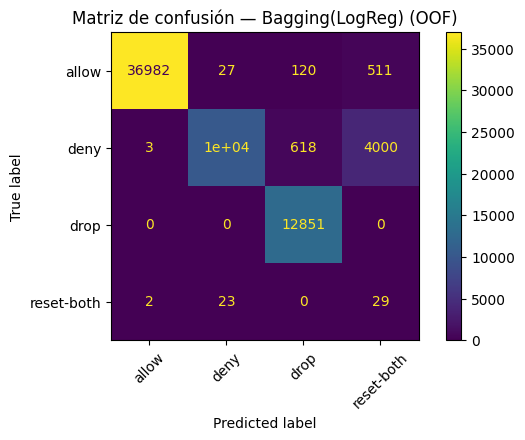

In [ ]:

# Logistic Regression multinomial
base_lr = LogisticRegression(
    solver='lbfgs',        
    multi_class='multinomial',
    class_weight='balanced',
    max_iter=500,          
)

pipe_bag_lr = Pipeline([
    ('prep', preprocess),
    ('clf', BaggingClassifier(
        estimator=base_lr,
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ))
])

grid_bag_lr = {
    'clf__n_estimators': [10, 20],   
    'clf__max_samples': [0.8, 1.0],   
    'clf__max_features': [0.8, 1.0],  
    'clf__bootstrap': [True],        
    'clf__estimator__C': [0.5, 1.0],

gs_bag_lr = GridSearchCV(
    pipe_bag_lr,
    grid_bag_lr,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    refit=True
)

gs_bag_lr.fit(X, y)
best_bag_lr = gs_bag_lr.best_estimator_

acc, f1m, bal = collect_scores(best_bag_lr, X, y)

# Guarda resultados globales
results['Bagging(LogReg)'] = {
    'accuracy_cv': acc,
    'f1_macro_cv': f1m,
    'balanced_accuracy_cv': bal,
    'best_params': gs_bag_lr.best_params_,
    'best_estimator': best_bag_lr
}

print("Best params:", gs_bag_lr.best_params_)
print(f"CV => acc={acc:.4f} | f1_macro={f1m:.4f} | bal_acc={bal:.4f}\n")

# Classification report (OOF) y matriz de confusión
summarize_cv(best_bag_lr, X, y, 'Bagging(LogReg)', le.classes_)



## 4.3 Bagging 

Best params: {'clf__bootstrap': True, 'clf__estimator__max_depth': None, 'clf__estimator__min_samples_leaf': 1, 'clf__max_features': 1.0, 'clf__max_samples': 1.0, 'clf__n_estimators': 200}
CV => acc=0.9983 | f1_macro=0.8764 | bal_acc=0.8479

              precision    recall  f1-score   support

       allow     0.9999    0.9997    0.9998     37640
        deny     0.9952    0.9973    0.9963     14987
        drop     0.9971    0.9979    0.9975     12851
  reset-both     0.9565    0.4074    0.5714        54

    accuracy                         0.9983     65532
   macro avg     0.9872    0.8506    0.8913     65532
weighted avg     0.9983    0.9983    0.9982     65532



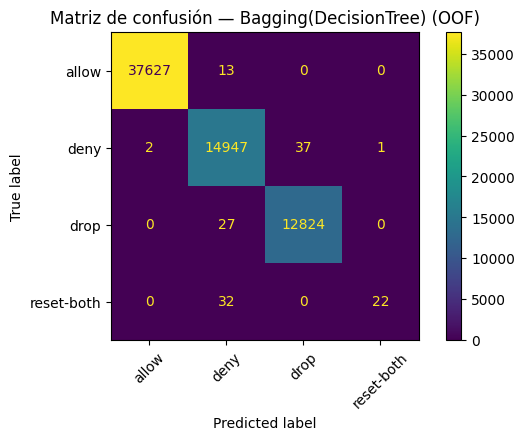

In [ ]:
## 4.3 Bagging
pipe_bag_dt = Pipeline([
    ('prep', preprocess),
    ('clf', BaggingClassifier(
        estimator=DecisionTreeClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced'
        ),
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

grid_bag_dt = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_samples': [0.8, 1.0],
    'clf__max_features': [0.8, 1.0],
    'clf__bootstrap': [True],
    'clf__estimator__max_depth': [None, 12, 24],
    'clf__estimator__min_samples_leaf': [1, 2]
}

gs_bag_dt = GridSearchCV(
    pipe_bag_dt, grid_bag_dt,
    cv=cv, scoring='f1_macro',
    n_jobs=-1, refit=True
)
gs_bag_dt.fit(X, y)
best_bag_dt = gs_bag_dt.best_estimator_

acc, f1m, bal = collect_scores(best_bag_dt, X, y)
results['Bagging(DecisionTree)'] = {
    'accuracy_cv': acc,
    'f1_macro_cv': f1m,
    'balanced_accuracy_cv': bal,
    'best_params': gs_bag_dt.best_params_,
    'best_estimator': best_bag_dt
}

print("Best params:", gs_bag_dt.best_params_)
print(f"CV => acc={acc:.4f} | f1_macro={f1m:.4f} | bal_acc={bal:.4f}\n")
summarize_cv(best_bag_dt, X, y, 'Bagging(DecisionTree)', le.classes_)


## 4.4 Random Forest

Best params: {'clf__max_depth': None, 'clf__max_features': 0.6, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 10, 'clf__n_estimators': 500}
CV => acc=0.9981 | f1_macro=0.8738 | bal_acc=0.8485

              precision    recall  f1-score   support

       allow     0.9999    0.9997    0.9998     37640
        deny     0.9947    0.9971    0.9959     14987
        drop     0.9971    0.9973    0.9972     12851
  reset-both     0.8148    0.4074    0.5432        54

    accuracy                         0.9981     65532
   macro avg     0.9517    0.8504    0.8840     65532
weighted avg     0.9980    0.9981    0.9980     65532



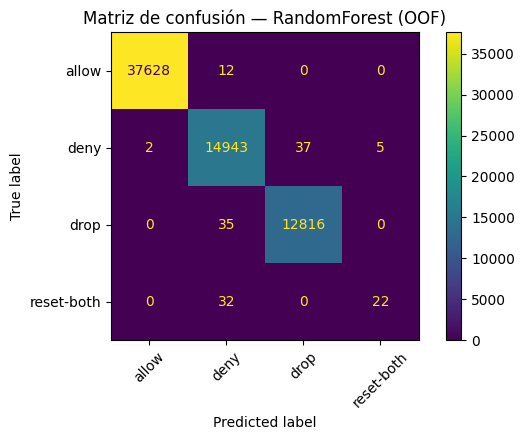

In [ ]:
## 4.4 Random Forest
pipe_rf = Pipeline([
    ('prep', preprocess),
    ('clf', RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight='balanced' 
    ))
])

grid_rf = {
    'clf__n_estimators': [300, 500],
    'clf__max_depth': [None, 20],
    'clf__min_samples_split': [2, 10],
    'clf__min_samples_leaf': [1, 2],
    'clf__max_features': ['sqrt', 0.6]
}

gs_rf = GridSearchCV(
    pipe_rf, grid_rf,
    cv=cv, scoring='f1_macro',
    n_jobs=-1, refit=True
)
gs_rf.fit(X, y)
best_rf = gs_rf.best_estimator_

acc, f1m, bal = collect_scores(best_rf, X, y)
results['RandomForest'] = {
    'accuracy_cv': acc,
    'f1_macro_cv': f1m,
    'balanced_accuracy_cv': bal,
    'best_params': gs_rf.best_params_,
    'best_estimator': best_rf
}

print("Best params:", gs_rf.best_params_)
print(f"CV => acc={acc:.4f} | f1_macro={f1m:.4f} | bal_acc={bal:.4f}\n")
summarize_cv(best_rf, X, y, 'RandomForest', le.classes_)


## 4.5 AdaBoost

Best params: {'clf__learning_rate': 0.2, 'clf__n_estimators': 200}
CV => acc=0.9553 | f1_macro=0.7253 | bal_acc=0.8853

              precision    recall  f1-score   support

       allow     1.0000    0.9920    0.9959     37640
        deny     0.9986    0.8257    0.9040     14987
        drop     0.9239    1.0000    0.9605     12851
  reset-both     0.0206    0.7222    0.0401        54

    accuracy                         0.9553     65532
   macro avg     0.7358    0.8850    0.7251     65532
weighted avg     0.9839    0.9553    0.9672     65532



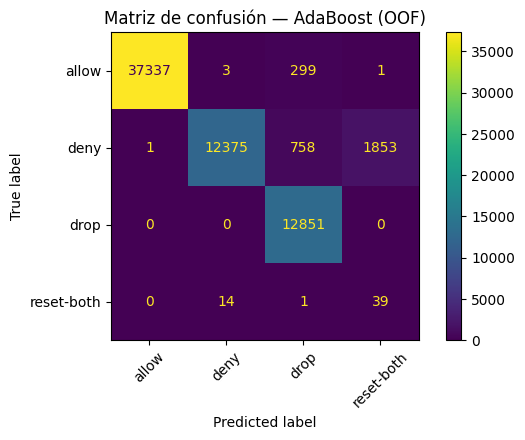

In [ ]:
## 4.5 AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

pipe_ada = Pipeline([
    ('prep', preprocess),
    ('clf', AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            max_depth=2,
            class_weight='balanced',
            random_state=RANDOM_STATE
        ),
        random_state=RANDOM_STATE
    ))
])

grid_ada = {
    'clf__n_estimators': [200, 400],
    'clf__learning_rate': [0.05, 0.1, 0.2]
}

gs_ada = GridSearchCV(
    pipe_ada, grid_ada,
    cv=cv, scoring='f1_macro',
    n_jobs=-1, refit=True
)
gs_ada.fit(X, y)
best_ada = gs_ada.best_estimator_

acc, f1m, bal = collect_scores(best_ada, X, y)
results['AdaBoost'] = {
    'accuracy_cv': acc,
    'f1_macro_cv': f1m,
    'balanced_accuracy_cv': bal,
    'best_params': gs_ada.best_params_,
    'best_estimator': best_ada
}

print("Best params:", gs_ada.best_params_)
print(f"CV => acc={acc:.4f} | f1_macro={f1m:.4f} | bal_acc={bal:.4f}\n")
summarize_cv(best_ada, X, y, 'AdaBoost', le.classes_)


## 4.6 XGBoost

Best params: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.2, 'clf__max_depth': 8, 'clf__min_child_weight': 1, 'clf__reg_lambda': 2.0, 'clf__subsample': 1.0}
CV => acc=0.9984 | f1_macro=0.8505 | bal_acc=0.8356

              precision    recall  f1-score   support

       allow     0.9999    0.9996    0.9998     37640
        deny     0.9967    0.9963    0.9965     14987
        drop     0.9969    1.0000    0.9984     12851
  reset-both     0.5938    0.3519    0.4419        54

    accuracy                         0.9984     65532
   macro avg     0.8968    0.8369    0.8591     65532
weighted avg     0.9983    0.9984    0.9983     65532



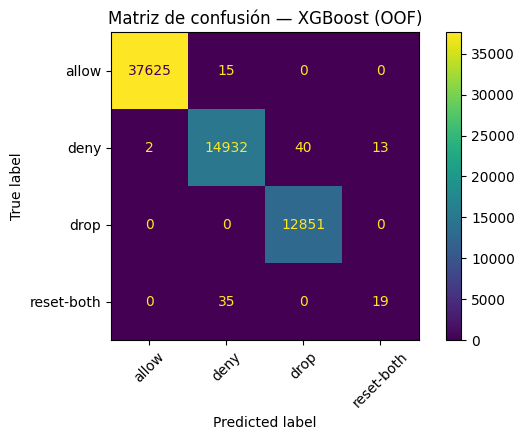

In [ ]:

pipe_xgb = Pipeline([
('prep', preprocess),
('clf', XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=RANDOM_STATE,
    n_estimators=400,
    n_jobs=-1,
    tree_method='hist'
))
])

grid_xgb = {
'clf__max_depth': [4, 8],
'clf__learning_rate': [0.1, 0.2],
'clf__subsample': [0.8, 1.0],
'clf__colsample_bytree': [0.8, 1.0],
'clf__reg_lambda': [1.0, 2.0],
'clf__min_child_weight': [1, 5]
}

gs_xgb = GridSearchCV(
pipe_xgb, grid_xgb,
cv=cv, scoring='f1_macro',
n_jobs=-1, refit=True
)
gs_xgb.fit(X, y)
best_xgb = gs_xgb.best_estimator_

acc, f1m, bal = collect_scores(best_xgb, X, y)
results['XGBoost'] = {
'accuracy_cv': acc,
'f1_macro_cv': f1m,
'balanced_accuracy_cv': bal,
'best_params': gs_xgb.best_params_,
'best_estimator': best_xgb
}

print("Best params:", gs_xgb.best_params_)
print(f"CV => acc={acc:.4f} | f1_macro={f1m:.4f} | bal_acc={bal:.4f}\n")
summarize_cv(best_xgb, X, y, 'XGBoost', le.classes_)


## 5) Comparación y selección del mejor

In [16]:

res_df = pd.DataFrame(results).T.sort_values('f1_macro_cv', ascending=False)
display(res_df)

best_name = res_df.index[0]
best_entry = results[best_name]
print("=== Mejor modelo ===")
print("Nombre:", best_name)
print("Métricas CV:", {k: float(v) for k,v in best_entry.items() if k.endswith('_cv')})
print("Hiperparámetros:", best_entry['best_params'])


,accuracy_cv,f1_macro_cv,balanced_accuracy_cv,best_params,best_estimator
DecisionTree,0.998093,0.889725,0.866756,"{'clf__criterion': 'gini', 'clf__max_depth': N...","(ColumnTransformer(transformers=[('num',\n ..."
Bagging(DecisionTree),0.998291,0.87644,0.847888,"{'clf__bootstrap': True, 'clf__estimator__max_...","(ColumnTransformer(transformers=[('num',\n ..."
RandomForest,0.998123,0.873791,0.848505,"{'clf__max_depth': None, 'clf__max_features': ...","(ColumnTransformer(transformers=[('num',\n ..."
XGBoost,0.998398,0.850483,0.83565,"{'clf__colsample_bytree': 1.0, 'clf__learning_...","(ColumnTransformer(transformers=[('num',\n ..."
AdaBoost,0.955289,0.725306,0.885251,"{'clf__learning_rate': 0.2, 'clf__n_estimators...","(ColumnTransformer(transformers=[('num',\n ..."
Bagging(LogReg),0.919062,0.697952,0.80188,"{'clf__bootstrap': True, 'clf__estimator__C': ...","(ColumnTransformer(transformers=[('num',\n ..."


=== Mejor modelo ===
Nombre: DecisionTree
Métricas CV: {'accuracy_cv': 0.9980925326092762, 'f1_macro_cv': 0.8897252371526377, 'balanced_accuracy_cv': 0.8667559702430794}
Hiperparámetros: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}


## 6) Guardado con `joblib`

In [ ]:
# === Guardar el mejor modelo y metadata EN LA MISMA CARPETA DEL NOTEBOOK ===
from pathlib import Path
import os, json, joblib

# Recupera el mejor y ajusta con todo el dataset
best_estimator = results[best_name]['best_estimator']
best_estimator.fit(X, y)

# Carpeta del notebook
NOTEBOOK_DIR = Path.cwd()

# Si querías seguir usando subcarpeta "artifacts", descomenta la siguiente línea:
# NOTEBOOK_DIR = NOTEBOOK_DIR / "artifacts"; NOTEBOOK_DIR.mkdir(exist_ok=True, parents=True)

MODEL_PATH = NOTEBOOK_DIR / "best_model.joblib"
METADATA_PATH = NOTEBOOK_DIR / "metadata.json"

# Guarda el paquete del modelo (pipeline + clases del encoder + features + info del mejor)
joblib.dump({
    "model": best_estimator,
    "label_encoder_classes": le.classes_,
    "numeric_features": numeric_features,
    "best_name": best_name,
    "best_params": results[best_name]['best_params']
}, MODEL_PATH)

# Si existe FILE_PATH en el entorno, úsalo; si no, deja None
dataset_path = globals().get("FILE_PATH", None)

# Metadata útil para reproducibilidad
with open(METADATA_PATH, "w", encoding="utf-8") as f:
    json.dump({
        "best_model_name": best_name,
        "best_params": results[best_name]["best_params"],
        "metrics_cv": {k: float(v) for k, v in results[best_name].items() if k.endswith('_cv')},
        "label_mapping": {cls: int(le.transform([cls])[0]) for cls in le.classes_},
        "dataset_path": dataset_path,
        "saved_at": str(MODEL_PATH.resolve())
    }, f, indent=2, ensure_ascii=False)

print("Modelo guardado en:", MODEL_PATH.resolve())
print("Metadata guardada en:", METADATA_PATH.resolve())


Modelo guardado en: D:\29092025\DESKTOP\Machine\best_model.joblib
Metadata guardada en: D:\29092025\DESKTOP\Machine\metadata.json


## 7) Ejemplo de inferencia

In [ ]:

bundle = joblib.load("artifacts/best_model.joblib")
loaded = bundle["model"]
classes = bundle["label_encoder_classes"]

sample = X.sample(5, random_state=RANDOM_STATE)
pred_idx = loaded.predict(sample)
pred_labels = [classes[i] for i in pred_idx]
pd.DataFrame({"pred": pred_labels, "true": y_text.loc[sample.index].values}, index=sample.index)

,pred,true
43957,deny,deny
4530,allow,allow
6666,allow,allow
25400,drop,drop
36054,allow,allow



## 8) Conclusiones.

Este proyecto me sirvió para responder una pregunta muy práctica: ¿podemos anticipar qué hará el firewall (allow/deny/drop/reset-both) solo mirando estadísticas del tráfico? Después de probar varias opciones con validación cruzada 10-fold y ajustar hiperparámetros, sí: se puede, y bastante bien.

¿Qué funcionó mejor?
El modelo que mejor balance logró entre todas las clases fue DecisionTree, con:

F1-macro (CV): 0.8897252371526377

Balanced accuracy (CV): 0.8667559702430794

Accuracy (CV): 0.9980925326092762

Hiperparámetros clave: {'clf__criterion': 'gini', 'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2}

Aclaro que no me quedé solo con accuracy, porque en este dataset allow domina. Por eso prioricé F1-macro y balanced accuracy para no “hacer trampa” con la clase mayoritaria. Aun así, el modelo mantiene muy buenos números en allow, deny y drop. reset-both es la más dura (pocas filas), y ahí todavía hay margen de mejora.

Qué variables parecen tener más peso (intuición):
Los volúmenes y actividad (Bytes, Bytes Sent/Received, Packets, pkts_sent/received) y la duración (Elapsed Time (sec)) aportan mucha señal. Los puertos (origen/destino y NAT) también ayudan a contextualizar servicios/políticas.

Limitaciones que vi:

El desbalance pega fuerte en reset-both. Si miras solo accuracy, te engañas.

El modelo no conoce las reglas del firewall; aprende patrones de los datos.

Ensambles como RF/XGB son menos “explicables” de una pasada; conviene usar SHAP o importancia por permutación si lo llevamos a operación.

Qué haría después (si tuviera un rato más):

Ajustar umbrales por clase para subir el recall de reset-both sin romper el resto.

Calibrar probabilidades para tomar decisiones con confianza (Platt/Isotónica).

Probar SMOTE o, si el objetivo del curso lo permite, una versión binaria (permitir vs bloquear).

Añadir interpretabilidad (SHAP) para justificar decisiones ante el equipo de redes/seguridad.

Si hay tiempo/fecha, hacer validación temporal (entrenar con un tramo y testear en otro).

Pensar en monitoreo: data drift, métricas por clase y alertas si cae el recall de la minoritaria.

En resumen: me quedo con que sí es posible predecir la acción del firewall con buen rendimiento y, sobre todo, sin sesgarse por la clase mayoritaria. Con dos o tres ajustes de los que dejé arriba, esto podría usarse como apoyo a decisiones para revisar políticas, simular cambios y priorizar eventos antes de tocar producción.
